In [25]:
%load_ext autoreload
%autoreload 1
import sys
import os
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).resolve().parent))

import pandas as pd 
pd.set_option('display.max_columns', 150)

from project.utils.data import *
%aimport project.utils.data
%aimport project.utils.metrics

from sktime.forecasting.all import temporal_train_test_split
import matplotlib.pyplot as plt

In [69]:
df = load_extended_data()

In [3]:
### to do

# choose df columns s. t. feature selection results 

In [70]:
df

,income,outcome,balance,income - outcome,non_working_day,non_working_day_usd,isholiday,key_rate,mosprime_rub_1m,mosprime_rub_1w,mosprime_rub_2m,mosprime_rub_2w,mosprime_rub_3m,mosprime_rub_6m,mosprime_rub_on,usd_xr,usd_xr_mean_7,usd_xr_std_7,usd_xr_min_7,usd_xr_max_7,usd_xr_median_7,day_before_holiday,day_after_holidays,tax,day_before_tax,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,start_of_month,end_of_month,year_2017,year_2018,year_2019,year_2020,year_2021,January,February,March,April,May,June,July,August,September,October,November,December
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-15,0.000000,0.000000,0.000000,0.000000,1,1,0,10.0,10.51,10.40,10.58,10.45,10.59,10.59,10.27,59.3700,59.843643,0.473536,59.3700,60.6569,59.8961,0.0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-16,1.082341,1.024345,0.057996,0.057996,0,1,0,10.0,10.47,10.42,10.51,10.44,10.52,10.52,10.32,59.3700,59.659800,0.334609,59.3700,60.1614,59.4978,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-17,0.896334,1.448364,-0.548519,-0.552030,0,0,0,10.0,10.46,10.42,10.49,10.44,10.50,10.50,10.37,59.6067,59.618457,0.318014,59.3700,60.1614,59.4978,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-18,0.754759,0.879560,-0.124801,-0.124801,0,0,0,10.0,10.46,10.42,10.49,10.44,10.50,10.50,10.38,59.4015,59.539629,0.288169,59.3700,60.1614,59.4015,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-19,0.949877,0.955268,-0.005391,-0.005391,0,0,0,10.0,10.46,10.48,10.49,10.48,10.50,10.50,10.43,59.1830,59.399857,0.130436,59.1830,59.6067,59.3700,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,0.000000,1,1,0,4.5,4.90,4.71,5.09,4.76,5.23,5.35,4.68,75.7576,75.190029,0.893932,74.1390,76.1741,75.3585,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-28,0.000000,0.000000,0.000000,0.000000,1,1,0,4.5,4.90,4.71,5.09,4.76,5.23,5.35,4.68,75.7576,75.421257,0.778663,74.1390,76.1741,75.7576,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2021-03-29,2.356883,3.370738,-1.017679,-1.013855,0,0,0,4.5,4.90,4.69,5.10,4.76,5.28,5.38,4.65,75.7576,75.652486,0.537367,74.6085,76.1741,75.7576,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [71]:
# creating lag features
X = (
    project.utils.data.create_lag_features(df, 'balance', [1, 7, 14])
    .drop(columns=['balance', 'income', 'outcome', 'income - outcome'])
)

# cutting nulls after creating lags 
start = X[X.isnull().sum(axis=1) == 0].index.min()

y, X = df['balance'][start:], X[start:]

assert y.shape[0] == X.shape[0], 'alarm (shape)'
assert y.index.min() == X.index.min(), 'alarm (dates)'

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error

def time_series_model_fit(target,
                          features,
                          params_grid,
                          model_class,
                          cv_window='expanding',
                          n_splits=5,
                          additional_metric=None,
                          test_size=0.2
                         ):
    # Step 1: Split time series data into train and test
    split_index = int(len(target) * (1 - test_size))
    target_train, target_test = target[:split_index], target[split_index:]
    features_train, features_test = features[:split_index], features[split_index:]

    # Step 2: Define Time Series Cross-Validation
    if cv_window == 'expanding':
        cv = TimeSeriesSplit(n_splits=n_splits if n_splits else len(target_train))
    elif cv_window == 'rolling':
        cv = TimeSeriesSplit(n_splits=n_splits)

    # Step 3: Run Grid Search CV on the train data
    grid_search = GridSearchCV(model_class, params_grid, cv=cv, scoring='neg_mean_absolute_error')
    grid_search.fit(features_train, target_train)

    best_model = grid_search.best_estimator_

    # Step 4: Evaluate the model on the test data
    predictions_test = best_model.predict(features_test)
    mae_test = mean_absolute_error(target_test, predictions_test)

    # Step 5: Fit the best model on all data
    best_model.fit(features, target)

    additional_metric_result = None
    if additional_metric:
        additional_metric_result = additional_metric(target_test, predictions_test)

    return best_model, mae_test, additional_metric_result, grid_search.best_params_



In [73]:
from catboost import  CatBoostRegressor

In [75]:
param_grid = {  
    'iterations': [100, 200, 300],  
    'learning_rate': [0.1, 1],  
    'depth': [5, 7, 8],  
    'l2_leaf_reg': [1, 5, 10],  
    # 'random_strength': [1, 5, 10],  
    # 'bagging_temperature': [0.5, 1, 2],  
    # 'random_seed': [0, 42, 123]  
}  
  
model = CatBoostRegressor(verbose=0) 

In [14]:
# y.to_numpy()

In [76]:
from sktime.forecasting.all import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.1)
cbr_rate_train, cbr_rate_test = df.key_rate[y_train.index], df.key_rate[y_test.index]

In [78]:
result = time_series_model_fit(
    target=y_train,
    features=X_train, 
    params_grid=param_grid
    , model_class=model, cv_window='rolling'
)

In [79]:
y_pred = result[0].predict(X_test)

In [80]:
y_test

date
2020-10-30   -0.307402
2020-10-31   -0.019446
2020-11-01    0.000000
2020-11-02   -0.834739
2020-11-03   -0.092355
                ...   
2021-03-27    0.000000
2021-03-28    0.000000
2021-03-29   -1.017679
2021-03-30   -0.259687
2021-03-31   -0.004878
Name: balance, Length: 153, dtype: float64

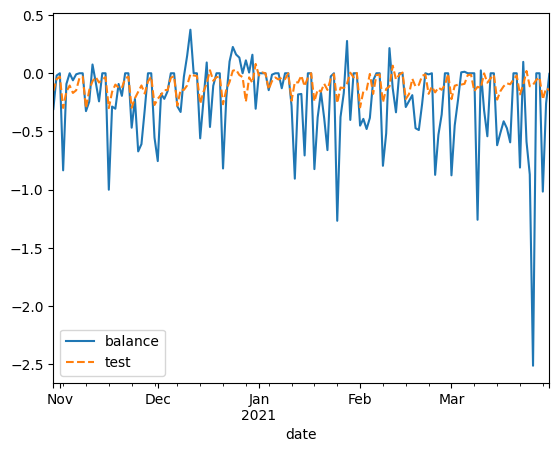

In [81]:
y_test.plot();
plt.plot(y_test.index, y_pred, linestyle='--', label='test');
plt.legend();

In [82]:
mean_absolute_error(y_test, y_pred)

0.21683769947889264

In [83]:
project.utils.metrics.calculate_add_margin(
    prediction=1.1,target=1.11,cbr_key_rate=5,
)

4.1068493150684955e-05

In [93]:
y_pred[i],y_test.to_numpy()[i]

(-0.15210531248681394, -0.3074023638010147)

In [95]:
i = 0

project.utils.metrics.calculate_add_margin(
    prediction=y_pred[i],target=y_test[i],cbr_key_rate=cbr_rate_test[i],
)

/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_32954/345354725.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediction=y_pred[i],target=y_test[i],cbr_key_rate=cbr_rate_test[i],


0

In [96]:
project.utils.metrics.calculate_total_add_margin(
predictions=y_pred, targets=y_test, cbr_key_rates=cbr_rate_test
)

3.8185585057121566e-05

In [7]:
i = 0
project.utils.metrics.calculate_add_margin(
    prediction=y_pred[i],target=y_test[i],cbr_key_rate=cbr_rate_test[i],
)

AttributeError: module 'project.utils' has no attribute 'metrics'

In [58]:
project.utils.metrics.calculate_total_earnings(y_pred, y_test, cbr_rate_test)

/Users/ruattar/TS_project/project/utils/metrics.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  profit = (earnings - target) / target
/Users/ruattar/TS_project/project/utils/metrics.py:56: RuntimeWarning: invalid value encountered in scalar multiply
  target * calculate_daily_profit(


nan

In [ ]:
class TS_Model:
    def __init__(self, y, X, test_size=0.1, cv_window, model_class=CatBoostRegressor):
        self.y = y
        self.X = X
        self.test_size=0.1
        self.cv_window = cv_window
        self.

In [39]:
%aimport project.utils.metrics

In [40]:
project.utils.metrics.check_business_requirements

<function project.utils.metrics.check_business_requirements(predictions: pandas.core.series.Series | numpy.ndarray, targets: pandas.core.series.Series | numpy.ndarray, max_deviation: float = 0.42) -> bool>

In [38]:
# class DoubleModel:
#     def __init__(self, income: dict, outcome: dict,  base_model_class,
#                  best_income_model=None, best_outome_model=None,
#                  test_size=0.1
#                 ):
#         self.income = income 
#         self.outcome = outcome
#         self.X = X
#         self.base_model_class = base_model_class
        
#         self.best_income_model = best_income_model
#         self.best_outome_model = best_outome_model

        

#     def fit_series(self, y, X):

        
        